In [184]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [185]:
seed = 2023 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [186]:
DATASETX = "./data/prep/HotelReservationsPreparedCleanX.csv"
DATASETY = "./data/prep/HotelReservationsY.csv"

In [187]:
df_x = pd.read_csv(DATASETX)
df_y = pd.read_csv(DATASETY)

In [188]:
df_x.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0


In [189]:
df_y.head()

,booking_status
0,1
1,1
2,1
3,0
4,1


In [190]:
df = pd.concat([df_x, df_y], axis=1)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0.0,-0.6,-1.000000,-0.882353,-1.0,1.0,-1.0,-0.990971,0.454545,-0.933333,0.0,-1.0,-1.0,-1.0,-0.044444,-0.6,1
1,0.0,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.823928,0.272727,-0.133333,-1.0,-1.0,-1.0,-1.0,-0.624074,-1.0,1
2,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.936795,1.000000,0.733333,0.0,-1.0,-1.0,-1.0,-0.603704,-1.0,1
3,0.0,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.548533,0.636364,0.000000,-1.0,-1.0,-1.0,-1.0,-0.600000,-1.0,0
4,-0.5,-1.0,-1.000000,-0.882353,0.0,-1.0,0.0,-0.002257,0.272727,-0.266667,-1.0,-1.0,-1.0,-1.0,-0.729630,-1.0,1


In [191]:
df = shuffle(df, random_state=seed)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
16377,-0.5,-1.0,-1.000000,-0.764706,0.0,-1.0,0.0,-0.665914,0.454545,0.133333,-1.0,-1.0,-1.0,-1.0,-0.677778,-1.0,1
24639,0.0,-1.0,-0.428571,-0.764706,-1.0,-1.0,0.0,-0.674944,-0.454545,0.466667,0.0,-1.0,-1.0,-1.0,-0.647407,-0.6,1
21974,0.0,-1.0,-0.428571,-1.000000,-1.0,1.0,1.0,-0.268623,-0.090909,0.666667,0.0,-1.0,-1.0,-1.0,-0.576667,-0.6,0
9205,0.0,-0.8,-1.000000,-0.647059,-1.0,-1.0,0.0,-0.503386,-0.454545,0.733333,0.0,-1.0,-1.0,-1.0,-0.643333,-0.6,1
33303,0.0,-1.0,-0.428571,-0.411765,-1.0,-1.0,1.0,-0.399549,0.090909,0.000000,0.0,-1.0,-1.0,-1.0,-0.575444,-0.6,1


In [192]:
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1

In [193]:
train_set, temp_set = train_test_split(df, train_size=TRAIN_SIZE, random_state=seed)

validation_set, test_set = train_test_split(temp_set, train_size=VALIDATION_SIZE / (VALIDATION_SIZE + TEST_SIZE), random_state=seed)

In [194]:
X_train = train_set.drop('booking_status', axis=1)
y_train = train_set['booking_status']

X_val = validation_set.drop('booking_status', axis=1)
y_val = validation_set['booking_status']

X_test = test_set.drop('booking_status', axis=1)
y_test = test_set['booking_status']

In [195]:
train_set.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
25003,-0.5,-1.0,-1.000000,-0.764706,-1.0,-1.0,0.0,-0.462754,-0.454545,-0.066667,0.0,-1.0,-1.0,-1.0,-0.663333,-1.0,1
34921,-0.5,-0.6,-0.714286,-0.529412,-1.0,-1.0,-1.0,-0.602709,-0.272727,0.000000,0.0,-1.0,-1.0,-1.0,-0.304259,-0.6,0
13102,0.0,-1.0,-1.000000,-0.647059,-1.0,-1.0,1.0,-0.399549,-0.090909,-0.533333,0.0,-1.0,-1.0,-1.0,-0.663148,-1.0,0
4487,0.0,-1.0,-1.000000,-0.647059,-1.0,-1.0,0.0,-0.688488,0.636364,0.600000,0.0,-1.0,-1.0,-1.0,-0.740778,-1.0,0
31249,0.5,-1.0,-1.000000,-0.529412,-1.0,-1.0,1.0,-0.128668,1.000000,0.800000,0.0,-1.0,-1.0,-1.0,-0.552963,-0.6,0


In [196]:
validation_set.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
23403,0.0,-1.0,-1.000000,-0.882353,-1.0,-1.0,-1.0,-1.000000,-1.000000,-0.600000,0.0,-1.0,-1.0,-1.0,-0.673148,-1.0,1
12427,-0.5,-1.0,-0.714286,-1.000000,1.0,-1.0,0.0,-0.959368,-0.636364,-0.600000,0.0,-1.0,-1.0,-1.0,-0.666667,-0.6,1
8230,0.5,-1.0,-1.000000,-0.764706,-1.0,-1.0,1.0,-0.557562,-0.272727,0.066667,0.0,-1.0,-1.0,-1.0,-0.376667,-1.0,0
15344,0.0,-1.0,-1.000000,-0.647059,-1.0,-1.0,0.0,-0.729120,0.454545,0.733333,0.0,-1.0,-1.0,-1.0,-0.496667,-1.0,0
35059,0.0,-1.0,-1.000000,-0.529412,-1.0,-1.0,0.0,-0.092551,0.818182,-1.000000,0.0,-1.0,-1.0,-1.0,-0.745185,0.2,1


In [197]:
test_set.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
20955,0.0,-1.0,-0.714286,-0.764706,-1.0,-1.0,0.0,-0.855530,0.636364,0.200000,0.0,-1.0,-1.0,-1.0,-0.643333,-0.6,1
33371,0.0,-1.0,-0.428571,-0.882353,-1.0,-1.0,0.0,-0.720090,0.090909,0.066667,0.0,-1.0,-1.0,-1.0,-0.610000,-0.6,1
22008,0.0,-1.0,-0.714286,-0.647059,-1.0,-1.0,0.0,-0.562077,-0.636364,0.533333,0.0,-1.0,-1.0,-1.0,-0.759333,-0.6,1
35320,0.0,-1.0,-0.714286,-0.882353,1.0,-1.0,0.0,-0.720090,-0.818182,-0.066667,0.0,-1.0,-1.0,-1.0,-0.820000,-1.0,1
25986,0.0,-1.0,-0.714286,-0.882353,-1.0,-1.0,0.0,-0.760722,0.636364,0.866667,0.0,-1.0,-1.0,-1.0,-0.603333,-0.6,0


In [198]:
print("Train: ", X_train.shape)
print("Test: ", X_test.shape)
print("Validation: ", X_val.shape)

Train:  (29016, 16)
Test:  (3627, 16)
Validation:  (3627, 16)


In [199]:
INPUTS = X_train.shape[1]
OUTPUTS = 1
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (X_val.shape[0]/1))

In [200]:
n_epochs = 1000
lr = 0.01
batch_size = 512
tasa_dropout = 0.4
n_neurons_per_hlayer = [1024, 512, 256, 124, 62, 31, 16, 8, 4, 2]

In [201]:
model = keras.Sequential(name="DeepFeedforward")

In [202]:
model.add(keras.layers.InputLayer(input_shape=(INPUTS,), batch_size=None))

for neurons in n_neurons_per_hlayer:
  model.add(keras.layers.Dense(neurons, kernel_initializer="he_normal", use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation("elu"))
  model.add(tf.keras.layers.Dropout(tasa_dropout))

model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "DeepFeedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 1024)              16384     
                                                                 
 batch_normalization_70 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 activation_70 (Activation)  (None, 1024)              0         
                                                                 
 dropout_70 (Dropout)        (None, 1024)              0         
                                                                 
 dense_78 (Dense)            (None, 512)               524288    
                                                                 
 batch_normalization_71 (Ba  (None, 512)               2048      
 tchNormalization)                                 

In [203]:
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_binary_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_binary_accuracy', factor=0.1, patience=45, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping('val_binary_accuracy', patience=101, verbose=1)
callbacks = [model_checkpoint, early_stop]

In [204]:
opt = Adam(learning_rate=lr)
#opt = SGD(learning_rate=0.1, momentum=0.9, nesterov=False)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=["binary_accuracy"]
)

In [205]:
start = time.perf_counter()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, callbacks=callbacks, validation_data=(X_val, y_val))
print (time.perf_counter() - start)
best_idx = int(np.argmax(history.history['val_binary_accuracy']))
best_value = np.max(history.history['val_binary_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_binary_accuracy ' + str(best_value))

Epoch 1/1000


c:\dev\DL\venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - ETA: 0s - loss: 0.6117 - binary_accuracy: 0.6703

c:\dev\DL\venv\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



Epoch 1: val_binary_accuracy improved from -inf to 0.73284, saving model to model.hdf5
57/57 [==============================] - 7s 54ms/step - loss: 0.6117 - binary_accuracy: 0.6703 - val_loss: 2.2553 - val_binary_accuracy: 0.7328
Epoch 2/1000
 1/57 [..............................] - ETA: 2s - loss: 0.5248 - binary_accuracy: 0.7520

c:\dev\DL\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 0.5282 - binary_accuracy: 0.7366
Epoch 2: val_binary_accuracy improved from 0.73284 to 0.79487, saving model to model.hdf5
57/57 [==============================] - 3s 48ms/step - loss: 0.5282 - binary_accuracy: 0.7368 - val_loss: 0.8300 - val_binary_accuracy: 0.7949
Epoch 3/1000
57/57 [==============================] - ETA: 0s - loss: 0.5156 - binary_accuracy: 0.7450
Epoch 3: val_binary_accuracy improved from 0.79487 to 0.79597, saving model to model.hdf5
57/57 [==============================] - 3s 46ms/step - loss: 0.5156 - binary_accuracy: 0.7450 - val_loss: 0.6117 - val_binary_accuracy: 0.7960
Epoch 4/1000
56/57 [============================>.] - ETA: 0s - loss: 0.5062 - binary_accuracy: 0.7548
Epoch 4: val_binary_accuracy improved from 0.79597 to 0.80618, saving model to model.hdf5
57/57 [==============================] - 3s 46ms/step - loss: 0.5063 - binary_accuracy: 0.7550 - val_loss: 0.4384 - val_binary_accuracy: 0.8062
Ep

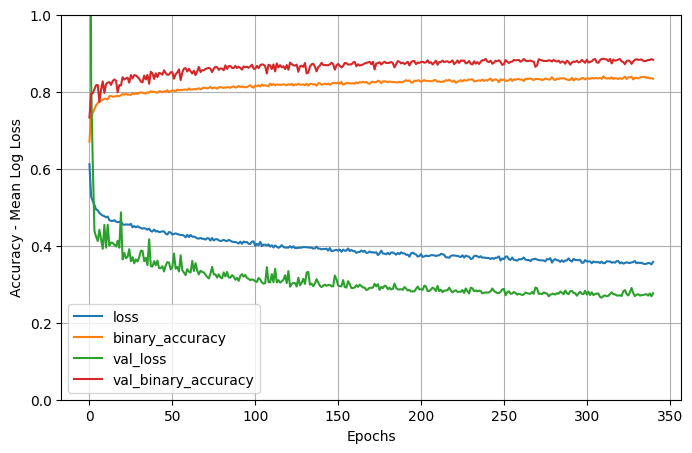

In [206]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig(f"./images/loss{n_neurons_per_hlayer}_{seed}_{n_epochs}_{results.val_binary_accuracy.values[-1:][0]}_{tasa_dropout}_{lr}.png")
plt.show()

In [207]:
results[-1:]

,loss,binary_accuracy,val_loss,val_binary_accuracy
340,0.357937,0.833678,0.276621,0.882823


In [208]:
print(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}")
print(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}"
)
print(f"Accuracy for the test set: {model.evaluate(X_test, y_test)[1]}")

Accuracy for the training set: 0.8336779475212097
Accuracy for the development test set: 0.8828232884407043
  1/114 [..............................] - ETA: 2s - loss: 0.4974 - binary_accuracy: 0.8438

114/114 [==============================] - 0s 4ms/step - loss: 0.2977 - binary_accuracy: 0.8608
Accuracy for the test set: 0.8607664704322815


In [209]:
v = open("./history/DeepFeedforward.txt", "a")
v.write(f"Epoque: {n_epochs}\n")
v.write(f"Learning Rate: {lr}\n")
v.write(f"Batch Size: {batch_size}\n")
v.write(f"Dropout: {tasa_dropout}\n")
v.write(f"Neurons per layer: {n_neurons_per_hlayer}\n")
v.write(f"Activation: elu\n")
v.write(f"Optimizer: Adam\n")
v.write(f"seed = {seed}\n")
v.write(
    "model.add(keras.layers.Dense(neurons, kernel_initializer=he_normal, use_bias=False)); model.add(keras.layers.BatchNormalization()); model.add(keras.layers.Activation(elu)); model.add(tf.keras.layers.Dropout(tasa_dropout))"
)
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.write(f"Accuracy for the training set: {results.binary_accuracy.values[-1:][0]}\n")
v.write(
    f"Accuracy for the development test set: {results.val_binary_accuracy.values[-1:][0]}\n"
)
v.write(f"Best validation model: epoch {best_idx+1} - val_binary_accuracy {best_value}\n")
v.write(f"Accuracy for the test set: {model.evaluate(X_test, y_test)[1]}\n")
v.write(f"Time: {time.perf_counter() - start}\n")
v.write(
    "--------------------------------------------------------------------------------------------\n"
)
v.close()

114/114 [==============================] - 0s 4ms/step - loss: 0.2977 - binary_accuracy: 0.8608


114/114 [==============================] - 1s 4ms/step


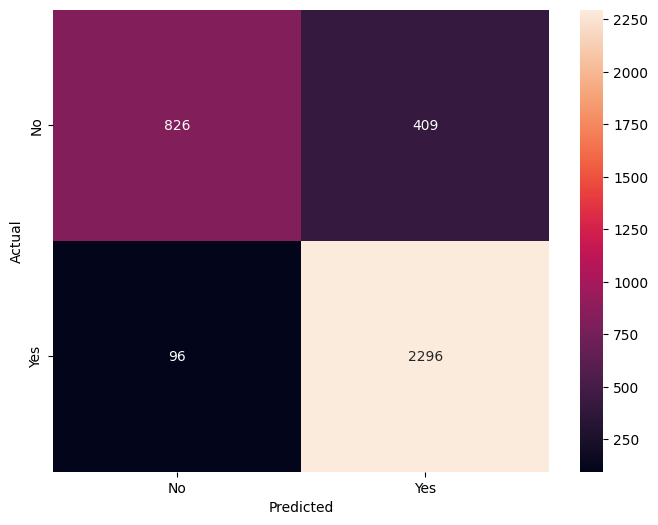

In [210]:
y_pred = model.predict(X_test).round()
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
